In [18]:
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import jaccard_score, multilabel_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from skopt import BayesSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin

In [2]:
x = np.load('../train.npy/X_train.npy')
Y_train = np.load('../train.npy/y_train.npy')
X_train = (x-np.min(x))/(np.max(x)-np.min(x))
xt = np.load('../test.npy/X_Test.npy')
Y_test = np.load('../test.npy/Y_Test.npy')
X_test = (xt-np.min(xt))/(np.max(xt)-np.min(xt))

In [3]:
x_add = np.load('../additional.npy/X_additional.npy')
y_add = np.load('../additional.npy/Y_additional.npy')
x_add = (x_add-np.min(x_add))/(np.max(x_add)-np.min(x_add))

In [4]:
Y = np.concatenate((Y_train, Y_test, y_add))
X = np.concatenate((X_train, X_test,x_add))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [5]:
X_train.shape

(1754, 20)

In [6]:
y_temp = Y_train[ : ,0]
np.count_nonzero(Y_train[ : ,10])

566

In [7]:
import warnings
warnings.filterwarnings("ignore")
mlp = MLPClassifier(activation = 'relu',hidden_layer_sizes = [200] ,solver = 'adam',alpha = 0.0009, batch_size = 200,
                    learning_rate_init=0.0046, max_iter = 57)
chains = [ClassifierChain(mlp, order="random", random_state=i) for i in range(10)]
for chain in chains:
    chain.fit(X_train, Y_train)

    #[('activation', 'relu'), ('alpha', 0.0009499129945054737), 
    #('hidden_layer_sizes', 200), ('learning_rate_init', 0.0045520277830559674), ('max_iter', 57)]

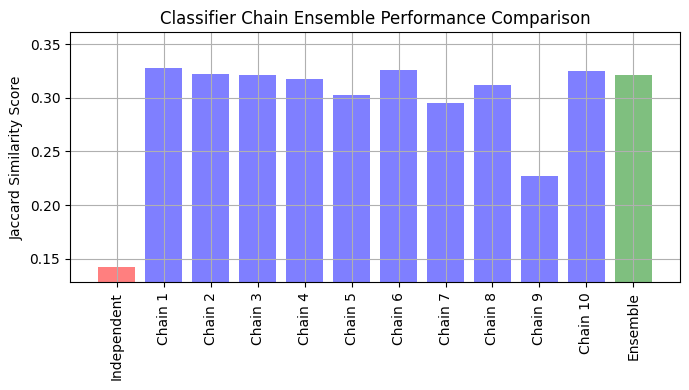

In [8]:
ovr = OneVsRestClassifier(mlp)
ovr.fit(X_train, Y_train)
Y_pred_ovr = ovr.predict(X_test)
ovr_jaccard_score = jaccard_score(Y_test, Y_pred_ovr, average="samples")

Y_pred_chains = np.array([chain.predict(X_test) for chain in chains])
chain_jaccard_scores = [
    jaccard_score(Y_test, Y_pred_chain >= 0.5, average="samples")
    for Y_pred_chain in Y_pred_chains
]

Y_pred_ensemble = Y_pred_chains.mean(axis=0)
ensemble_jaccard_score = jaccard_score(
    Y_test, Y_pred_ensemble >= 0.5, average="samples"
)

model_scores = [ovr_jaccard_score] + chain_jaccard_scores
model_scores.append(ensemble_jaccard_score)

model_names = (
    "Independent",
    "Chain 1",
    "Chain 2",
    "Chain 3",
    "Chain 4",
    "Chain 5",
    "Chain 6",
    "Chain 7",
    "Chain 8",
    "Chain 9",
    "Chain 10",
    "Ensemble",
)

x_pos = np.arange(len(model_names))

# Plot the Jaccard similarity scores for the independent model, each of the
# chains, and the ensemble (note that the vertical axis on this plot does
# not begin at 0).

fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(True)
ax.set_title("Classifier Chain Ensemble Performance Comparison")
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation="vertical")
ax.set_ylabel("Jaccard Similarity Score")
ax.set_ylim([min(model_scores) * 0.9, max(model_scores) * 1.1])
colors = ["r"] + ["b"] * len(chain_jaccard_scores) + ["g"]
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()

In [9]:
Y_pred_chains[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
# Define the MLPClassifier
mlp = MLPClassifier()
# Define the search space for hyperparameters , (50, 50), (100, 50)
search_space = {
    'hidden_layer_sizes': [(50), (100)],
    'activation': ['relu', 'tanh'],
    'alpha': (1e-4, 1e-2, 'log-uniform'),
    'learning_rate_init': (0.0001, 0.1, 'log-uniform'),
    'max_iter': (100, 200),
}

# Define the Bayesian optimization object
opt = BayesSearchCV(mlp, search_space, n_iter=50, cv=5, n_jobs=-1)

# Perform the hyperparameter tuning
opt.fit(X_train, Y_train)

# Print the best parameters and best score
print("Best parameters found: ", opt.best_params_)
print("Best score: ", opt.best_score_)

Best parameters found:  OrderedDict([('activation', 'tanh'), ('alpha', 0.008165076788556257), ('hidden_layer_sizes', 96), ('learning_rate_init', 0.02440488934780248), ('max_iter', 193)])
Best score:  0.11513878713878715


In [11]:
# Define the MLPClassifier
mlp = MLPClassifier()
# Define the search space for hyperparameters , (50, 50), (100, 50)
search_space = {
    'hidden_layer_sizes': [(100), (200), (50)],#, (40, 20), (50, 30)],
    'activation': ['logistic', 'relu', 'tanh'],
    'alpha': (1e-5, 1e-2, 'log-uniform'),
    'learning_rate_init': (0.0001, 0.1, 'log-uniform'),
    'max_iter': (50, 200),
}

# Define the Bayesian optimization object
opt = BayesSearchCV(mlp, search_space, n_iter=50, cv=5, n_jobs=-1)

# Perform the hyperparameter tuning
opt.fit(X_train, Y_train[ : ,10])

# Print the best parameters and best score
print("Best parameters found: ", opt.best_params_)
print("Best score: ", opt.best_score_)

Best parameters found:  OrderedDict([('activation', 'tanh'), ('alpha', 0.01), ('hidden_layer_sizes', 50), ('learning_rate_init', 0.0031200070264665748), ('max_iter', 167)])
Best score:  0.7081155881155882


In [12]:
class ChainMLP(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_layer_sizes, activation, solver, alpha, batch_size, learning_rate, learning_rate_init, 
                 max_iter, shuffle, warm_start):
        super(ChainMLP, self).__init__()
        self.activation = activation
        self.hidden_layer_sizes = hidden_layer_sizes
        self.alpha = alpha
        self.learning_rate_init = learning_rate_init
        self.max_iter = max_iter
        self.model = MLPClassifier(activation = activation, hidden_layer_sizes = hidden_layer_sizes ,solver = 'adam',
                                   alpha = alpha, batch_size = 200, learning_rate_init= learning_rate_init, max_iter = max_iter)
        self.chain = ClassifierChain(self.model, order="random", random_state=1)
        self.solver = solver
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.shuffle = shuffle
        self.warm_start = warm_start
    def fit(self, X_train, Y_train):
        #self.chain = ClassifierChain(self.model, order="random", random_state=1)
        return self.chain.fit(X_train, Y_train)
    
    def score(self, X_test, Y_test):
        Y_pred_chain = self.chain.predict(X_test)
        chain_jaccard_score = jaccard_score(Y_test, Y_pred_chain >= 0.5, average="samples")
        return chain_jaccard_score
        
        

In [13]:
search_space = {
    'hidden_layer_sizes': [(100), (200), (50)],#, (40, 20), (50, 30)],
    'activation': ['identity', 'logistic', 'relu', 'tanh'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': (1e-5, 1e-2, 'log-uniform'),
    'batch_size': [50, 100, 200, 500],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': (0.0001, 0.1, 'log-uniform'),
    'max_iter': (50, 200),
    'shuffle': [True, False],
    'warm_start':[True, False],
    
}

test = ChainMLP((100), activation = 'tanh', solver = 'adam', alpha= 0.001,learning_rate='constant', 
                learning_rate_init= 0.01, batch_size=200, max_iter = 200, shuffle = True, warm_start = True)
opt = BayesSearchCV(test, search_space, n_iter=50, cv=7, n_jobs=-1)
opt.fit(X_train, Y_train)

BayesSearchCV(cv=7,
              estimator=ChainMLP(activation='tanh', alpha=0.001, batch_size=200,
                                 hidden_layer_sizes=100,
                                 learning_rate='constant',
                                 learning_rate_init=0.01, max_iter=200,
                                 shuffle=True, solver='adam', warm_start=True),
              n_jobs=-1,
              search_spaces={'activation': ['identity', 'logistic', 'relu',
                                            'tanh'],
                             'alpha': (1e-05, 0.01, 'log-uniform'),
                             'batch_size': [50, 100, 200, 500],
                             'hidden_layer_sizes': [100, 200, 50],
                             'learning_rate': ['constant', 'invscaling',
                                               'adaptive'],
                             'learning_rate_init': (0.0001, 0.1, 'log-uniform'),
                             'max_iter': (50, 200), 'shuffle': [True, False],
                             'solver': ['lbfgs', 'sgd', 'adam'],
                             'warm_start': [True, False]})

In [14]:
print("Best parameters found: ", opt.best_params_)
print("Best score: ", opt.best_score_)

Best parameters found:  OrderedDict([('activation', 'identity'), ('alpha', 3.5422731453651636e-05), ('batch_size', 50), ('hidden_layer_sizes', 100), ('learning_rate', 'constant'), ('learning_rate_init', 0.058239655344369104), ('max_iter', 114), ('shuffle', False), ('solver', 'lbfgs'), ('warm_start', True)])
Best score:  0.34417328780117623


In [16]:
import warnings
warnings.filterwarnings("ignore")
mlp = MLPClassifier(activation = 'identity',hidden_layer_sizes = [100] ,solver = 'lbfgs',alpha = 0.00003, batch_size = 50,
                    learning_rate_init=0.058, max_iter = 114, warm_start=True)
chains = [ClassifierChain(mlp, order="random", random_state=i) for i in range(10)]
for chain in chains:
    chain.fit(X_train, Y_train)

Y_pred_chains = np.array([chain.predict(X_test) for chain in chains])
chain_jaccard_scores = [
    jaccard_score(Y_test, Y_pred_chain >= 0.5, average="samples")
    for Y_pred_chain in Y_pred_chains
]

Y_pred_max = Y_pred_chains.max(axis=0)

In [17]:
chain_jaccard_scores

[0.43934472934472935,
 0.4421367521367522,
 0.42561253561253565,
 0.41803418803418807,
 0.46213675213675215,
 0.4437606837606838,
 0.43800569800569805,
 0.4426495726495726,
 0.4283190883190883,
 0.4267236467236467]

In [70]:
m = multilabel_confusion_matrix(Y_test, Y_pred_chains[4])

In [71]:
tp = sum(m[:,1,1])
fp = sum(m[:,0,1])
tn = sum(m[:,0,0])
fn = sum(m[:,1,0])

In [72]:
print(tp, fp, tn, fn)

465 368 5090 512


In [73]:
precision = [x[1,1]/(x[1,1]+x[0,1]) for x in m]

In [74]:
precision

[0.6923076923076923,
 0.6,
 0.5,
 0.5409836065573771,
 0.6423841059602649,
 0.38095238095238093,
 0.5939849624060151,
 0.42424242424242425,
 0.0,
 0.6666666666666666,
 0.49572649572649574]

In [75]:
m

array([[[563,   4],
        [  9,   9]],

       [[562,   2],
        [ 18,   3]],

       [[552,   5],
        [ 23,   5]],

       [[446,  28],
        [ 78,  33]],

       [[339,  54],
        [ 95,  97]],

       [[502,  13],
        [ 62,   8]],

       [[270, 108],
        [ 49, 158]],

       [[487,  19],
        [ 65,  14]],

       [[551,   6],
        [ 28,   0]],

       [[522,  11],
        [ 30,  22]],

       [[296, 118],
        [ 55, 116]]], dtype=int64)